# Ancestry Common Ancestor Analysis

## Notes
- Simple toy model to investigate problem.
- Sex of nodes is not taken into account.

## Further Work
- ~~FIXME: First element of population seems to always have no descendants.~~
    - np.random.randint *high* parameter is exclusive; add one to max value to fix.


## Reference
- Joseph T. Chang, Recent Common Ancestor of All Present-Day Individuals (1998) - http://www.stat.yale.edu/~jtc5/papers/Ancestors.pdf
- *EVERY baby is a ROYAL baby* - **Numberphile** - https://www.youtube.com/watch?v=Fm0hOex4psA

In [1]:
import numpy as np
import networkx as nx

from networkx.algorithms.dag import ancestors, descendants

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
VERBOSE = False  # HACK: pre-refactor

In [3]:
def ancestor_history_layout(population_node_list):
    pos = {}
    for i, nodes in enumerate(population_node_list):
        ys = np.linspace(-10, 10, len(nodes))
        for node, y in zip(nodes, ys):
            pos[node] = i, y
    return pos

In [4]:
def apply_alpha(colours: list, alpha: float) -> list:
    return list(map(lambda c: tuple(x + (1 - x) * (1 - alpha) for x in c), colours))

In [5]:
# populations = [100, 90, 75, 50, 25, 13, 5]

# europe approx every 50y (in millions)
# populations = [743, 635, 429, 276, 203, 163, 120, 100, 102, 84, 69, 63, 60, 68, 85, 78, 67, 61, 56]  

populations = np.repeat(10, 12)
population_node_list = []

node_index = 0
for i, p in enumerate(populations):
    x = 0 if i == 0 else sum(populations[:i])
    population_node_list.append(list(range(1 + x, p + x + 1)))
    
# [np.array(x) for x in population_node_list]

In [6]:
G = nx.DiGraph()

for generation, nodes in enumerate(population_node_list):
    for node in nodes:
        G.add_node(node, generation=generation)
        
for g, population in enumerate(population_node_list):
    if g + 1 < len(population_node_list):
        if VERBOSE:
            print(f"{g} | {population}")
        for child in population:
            p_min, p_max = min(population_node_list[g+1]), max(population_node_list[g+1])
            
            # TODO: make sure parent_x != parent_y
            parent_x, parent_y = np.random.randint(p_min, p_max + 1, 2)  # high is exclusive; hence p_max + 1
            if VERBOSE:
                print(f"  {child} | ({parent_x}, {parent_y})")
            G.add_edge(child, parent_x, generation=g)
            G.add_edge(child, parent_y, generation=g)


In [7]:
common_ancestors = []
mrca_generation = len(populations) + 1  # most recent common ancestor generation

for generation, nodes in enumerate(population_node_list):
    if generation > 0:
        for node in nodes:
            n_ancestors = len(ancestors(G, node))
            if n_ancestors == len(population_node_list[generation-1]):
                common_ancestors.append(node)
                if VERBOSE:
                    print(f"generation {generation} | (node {node}) n_ancestors={n_ancestors} -> COMMON ANCESTOR")
                if generation < mrca_generation:
                    mrca_generation = generation
            else:
                if VERBOSE:
                    print(f"generation {generation} | (node {node}) n_ancestors={n_ancestors}")
                
print(f"\nbase common ancestors: {common_ancestors}\n")
print(f"most recent common ancestor generation: {mrca_generation}\n")

implied_common_ancestors = set(common_ancestors)
for node in common_ancestors:
    implied_common_ancestors.update(descendants(G, node))
    
implied_common_ancestors = list(implied_common_ancestors)
    
print(f"implied common ancestors: {implied_common_ancestors}\n")


no_descendant_nodes = [node for node, in_degree in G.in_degree() if in_degree==0 and node > populations[0]]
print(f"no relation or descendant nodes: {no_descendant_nodes}\n")


identical_ancestors_generation = None
for generation, nodes in enumerate(population_node_list):
    if len(set(nodes).intersection(set(implied_common_ancestors) | set(no_descendant_nodes))) == len(nodes):
        identical_ancestors_generation = generation
        break
        
print(f"identical ancestors generation: {identical_ancestors_generation}")


base common ancestors: [34]

most recent common ancestor generation: 3

implied common ancestors: [34, 47, 49, 51, 58, 59, 60, 61, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 80, 81, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120]

no relation or descendant nodes: [18, 19, 28, 30, 37, 42, 82, 90, 106, 114]

identical ancestors generation: 8


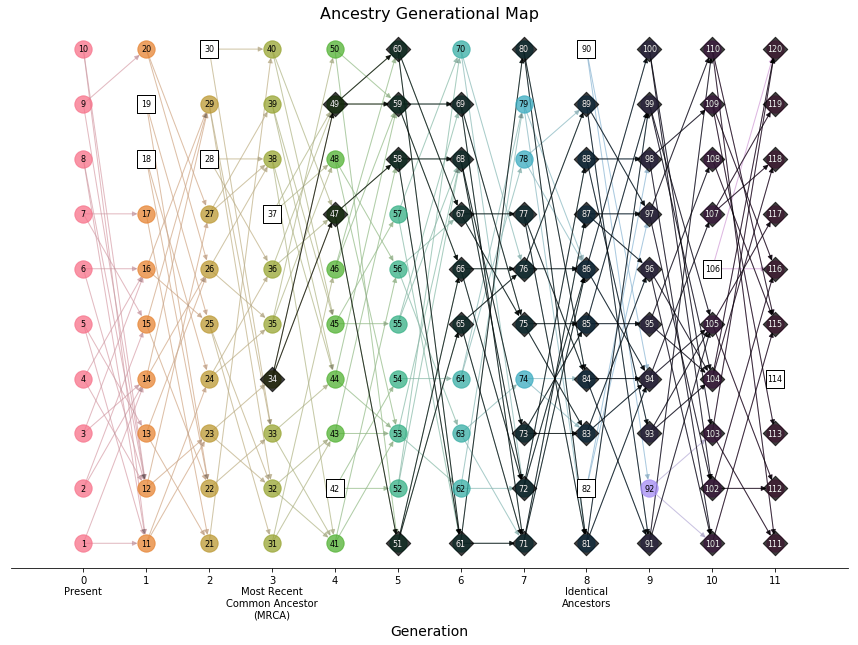

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

label_font_size = 8

pos = ancestor_history_layout(population_node_list)

shell_colours = sns.color_palette("husl", len(population_node_list))

for shell, colour in zip(population_node_list, shell_colours):
    nx.draw_networkx_nodes(G, pos, nodelist=shell, node_color=colour, alpha=0.75)
    
for g, colour in zip(range(len(population_node_list)), shell_colours):
    generation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['generation']==g]
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=generation_edges, 
        edge_color=apply_alpha([colour for _ in range(len(generation_edges))], 0.33)  # embedded alpha,
    )
    
nx.draw_networkx_labels(G, pos, font_size=label_font_size)

# common ancestors + implied
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=implied_common_ancestors, 
    node_color='k', 
    alpha=0.75, 
    node_shape='D'
)

nx.draw_networkx_edges(
    G, pos, 
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if u in implied_common_ancestors], 
    edge_color='k',
    alpha=0.75
)

nx.draw_networkx_labels(
    G, pos, 
    labels={c: c for c in implied_common_ancestors}, 
    font_color='w',
    font_size=label_font_size
)


# common ancestors + implied (draw descendant edges)
common_ancestor_descendants = []
for a in implied_common_ancestors:
    common_ancestor_descendants.extend(ancestors(G, a))

nx.draw_networkx_edges(
    G, pos, 
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if u in common_ancestor_descendants], 
    edge_color='k',
    alpha=0.10
)

# ancestor lines that died out (no relation to present/initial generation)
no_descendant_nodes = [node for node, in_degree in G.in_degree() if in_degree==0 and node > populations[0]]

nodes = nx.draw_networkx_nodes(
    G, pos, 
    nodelist=no_descendant_nodes, 
    node_color='w', 
#     edgecolor='k',
    node_shape='s'
)
nodes.set_edgecolor('k')



# plot formatting
plt.title('Ancestry Generational Map', fontsize=16)

plt.xlabel('Generation', fontsize=14)
locs, labels = plt.xticks()
labels = list(map(str, range(len(populations))))
labels[0] = f"{0}\nPresent"

if mrca_generation != len(populations) + 1:
    labels[mrca_generation] = f"{mrca_generation}\nMost Recent\nCommon Ancestor\n(MRCA)"

if identical_ancestors_generation is not None:
    labels[identical_ancestors_generation] = f"{identical_ancestors_generation}\nIdentical\nAncestors"
    
plt.xticks(np.arange(len(labels)), labels)

ax.get_yaxis().set_visible(False)


# ax.set_ylim(-10.5, 10.5)
ax.set_ylim(-11, 11)

ax.spines['top'].set_color(None)
ax.spines['left'].set_color(None)
ax.spines['right'].set_color(None)

# plt.tight_layout()

plt.show()